This notebook implements a binary classification model for the cat/non-cat dataset using a pretrained ResNet-18 model.

**Dataset:**
- Training: 209 images from `train_catvnoncat.h5`
- Testing: 50 images from `test_catvnoncat.h5`


In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision import transforms, models

In [2]:
class CatDataset(Dataset):
    """
    Custom dataset class for loading cat/non-cat images from h5 files.
    Applies transformations to prepare images for ResNet-18.
    """
    def __init__(self, h5_path, transform=None):
        # Load the h5 file containing images and labels
        with h5py.File(h5_path, 'r') as f:
            # Images are stored with shape (num_samples, height, width, channels)
            # Values are uint8 (0-255)
            self.images = np.array(f['train_set_x' if 'train' in h5_path else 'test_set_x'])
            # Labels are binary: 0 (non-cat) or 1 (cat)
            self.labels = np.array(f['train_set_y' if 'train' in h5_path else 'test_set_y'])

        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.images)

    def __getitem__(self, idx):
        # Get image at index idx
        image = self.images[idx]
        label = float(self.labels[idx])

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

Define transformations to prepare images for the pretrained ResNet-18 model.

The transforms ensure images are:
1. Resized to $224 \times 224$ pixels (ResNet input size)
2. Normalized using ImageNet statistics: $\mu = [0.485, 0.456, 0.406]$ and $\sigma = [0.229, 0.224, 0.225]$

In [3]:
# Pipeline for preprocessing of the image
transform = transforms.Compose([
    # Convert numpy array (H x W x C) to PIL Image
    transforms.ToPILImage(),

    # Resize to 224x224 to match ImageNet input size
    transforms.Resize((224, 224)),

    # Randomly flip images horizontally for data augmentation (50% probability)
    transforms.RandomHorizontalFlip(),

    # Convert PIL Image to PyTorch tensor with shape (C x H x W)
    # Pixel values are automatically scaled to [0, 1]
    transforms.ToTensor(),

    # Normalize using ImageNet dataset statistics
    # This helps the pretrained model perform better
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Load the training and test datasets, then wrap them in DataLoaders for batch processing.

In [4]:
# Create dataset instances
train_dataset = CatDataset('train_catvnoncat.h5', transform=transform)
test_dataset = CatDataset('test_catvnoncat.h5', transform=transform)

# Create DataLoaders for batch processing
# batch_size=16: Process 16 images at a time
# shuffle=True: Randomize training data order each epoch to prevent overfitting
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 209
Test samples: 50


Load a pretrained ResNet-18 model and modify it for binary classification.

**Transfer Learning Strategy:**
- Use ResNet-18 pretrained on ImageNet (1000 classes)
- Replace the final fully connected layer to output 1 value for binary classification
- Fine-tune all layers on our cat/non-cat dataset

In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load pretrained ResNet-18 model from torchvision
# pretrained=True loads weights learned from ImageNet
model = models.resnet18(pretrained=True)

# Get the number of input features to the final layer
num_features = model.fc.in_features

# Replace the final fully connected layer
# Original: 512 -> 1000 (ImageNet classes)
# Modified: 512 -> 1 (binary classification)
model.fc = nn.Linear(num_features, 1)

# Move model to GPU if available
model = model.to(device)

Define the loss function, optimizer, and learning rate scheduler.

**Loss Function:** Binary Cross-Entropy with Logits
$$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N}\left[y_i \log(\sigma(z_i)) + (1-y_i)\log(1-\sigma(z_i))\right]$$

where $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function.

In [8]:
# Binary Cross-Entropy Loss with Logits
# Combines sigmoid activation and BCE loss for numerical stability
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer with learning rate 1e-5
# Adam adapts learning rates for each parameter
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Learning rate scheduler: reduce LR by factor of gamma every step_size epochs
# This helps fine-tune the model as training progresses
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Number of training epochs
num_epochs = 20

Train the model using gradient descent and track training loss over epochs.

In [9]:
# Track training history
train_losses = []

for epoch in range(num_epochs):
    # Set model to training mode (enables dropout, batch norm updates)
    model.train()
    running_loss = 0.0

    # Iterate over batches in training set
    for images, labels in train_loader:
        # Move data to GPU if available
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # Shape: (batch_size, 1)

        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        outputs = model(images)

        # Compute loss between predictions and ground truth
        loss = criterion(outputs, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters using gradients
        optimizer.step()

        # Accumulate loss for this batch
        running_loss += loss.item() * images.size(0)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Update learning rate according to scheduler
    scheduler.step()

    # Print progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch [2/20], Loss: 0.5549
Epoch [4/20], Loss: 0.3341
Epoch [6/20], Loss: 0.2113
Epoch [8/20], Loss: 0.1883
Epoch [10/20], Loss: 0.1843
Epoch [12/20], Loss: 0.1759
Epoch [14/20], Loss: 0.2095
Epoch [16/20], Loss: 0.1917
Epoch [18/20], Loss: 0.1937
Epoch [20/20], Loss: 0.1754
Training completed!


Calculate test accuracy and identify misclassified images.

In [10]:
# Set model to evaluation mode (disables dropout, batch norm uses running stats)
model.eval()

# Lists to store predictions and ground truth
all_predictions = []
all_labels = []
all_outputs = []

# Disable gradient computation for evaluation (saves memory and computation)
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass: get model outputs
        outputs = model(images).squeeze()

        # Apply sigmoid to convert logits to probabilities
        # Then threshold at 0.5 to get binary predictions
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)

# Calculate test accuracy
test_accuracy = np.mean(all_predictions == all_labels)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

# Find indices of misclassified images (0-indexed)
misclassified_indices = np.where(all_predictions != all_labels)[0]
print(f"\nNumber of misclassified images: {len(misclassified_indices)}")
print(f"Misclassified indices: {misclassified_indices.tolist()}")


Test Set Accuracy: 0.9800

Number of misclassified images: 1
Misclassified indices: [13]


Visualize at least 4 failed cases to understand where the model struggles.

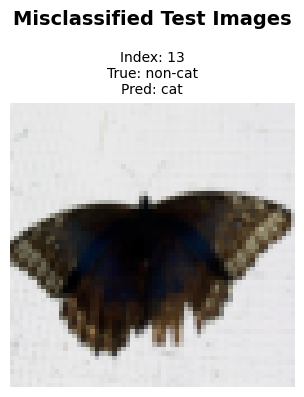

In [11]:
# Display up to 4 misclassified images
num_display = min(4, len(misclassified_indices))

if num_display > 0:
    fig, axes = plt.subplots(1, num_display, figsize=(15, 4))

    # Handle case where there's only 1 misclassified image
    if num_display == 1:
        axes = [axes]

    # Load original images from test set (without transforms)
    with h5py.File('test_catvnoncat.h5', 'r') as f:
        test_images = np.array(f['test_set_x'])

    for i, idx in enumerate(misclassified_indices[:num_display]):
        # Get original image
        img = test_images[idx]
        true_label = int(all_labels[idx])
        pred_label = int(all_predictions[idx])

        # Class names
        class_names = ['non-cat', 'cat']

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Index: {idx}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                         fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Misclassified Test Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("All test images were classified correctly!")

Visualize how the loss decreased during training.

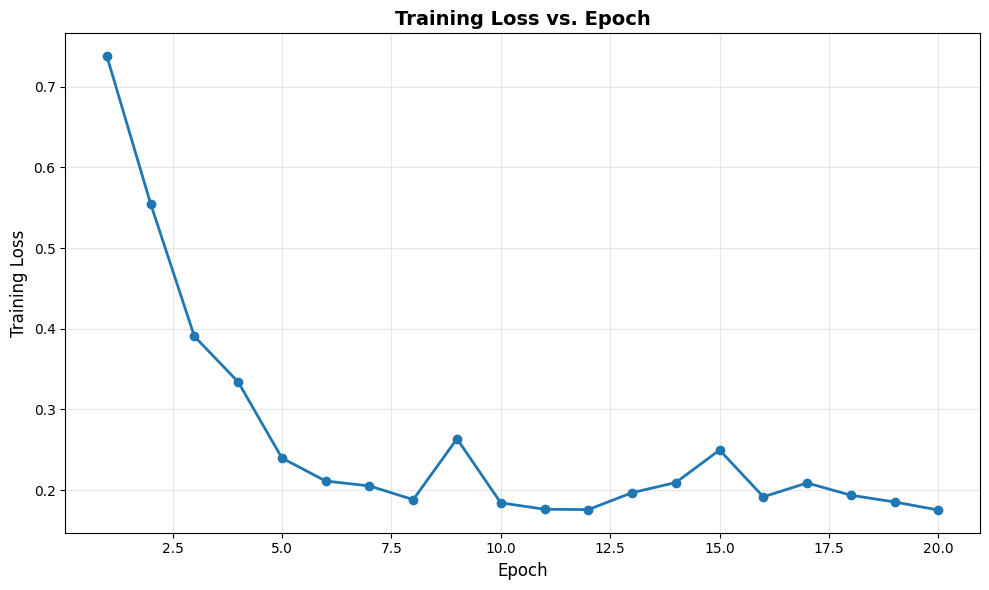

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss vs. Epoch', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()